In [3]:
import numpy as np
import matplotlib.pyplot as plt
from random import random
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers

### Dataset 01

In [4]:
def create_dataset_01():
    Centers = [
        (0,0),
        (1,1),
        (2,1),
        (1,3)
    ]
    Centers = np.array(Centers)
    Points = []
    for center in Centers:
        var = np.array([[1, .5], [0, 2]])
        Points.append(
            np.random.multivariate_normal(
                center,
                0.05 * var,
                100
            )
        )
    Points = np.vstack(Points)
    return Points

C:\Users\gaura\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  app.launch_new_instance()


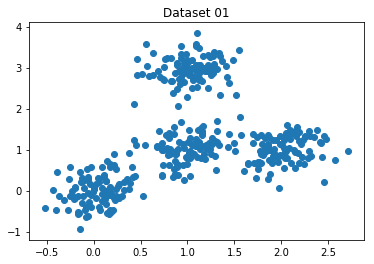

In [5]:
np.random.seed(100)
Points = create_dataset_01()
plt.scatter(Points[:, 0], Points[:, 1])
plt.title("Dataset 01")
plt.show()

Dataset 01 appear to have 4 clusters

### Dataset 02

In [6]:
def create_dataset_02():
    def line0(x):
        return (x, 10 - x ** 2 + (random() - 0.5))

    Points = []
    for _ in range(1000):
        x = 5 * (random() - 0.5)
        point = line0(x)
        Points.append(point)

    def line1(x):
        return (x, 5 * random() + ((x) * (x - 8)) + 5)

    for _ in range(1000):
        x = 5 * (random() + .1)
        point = line1(x)
        Points.append(point)

    Points = np.array(Points)
    return np.vstack(
        [
            Points,
            np.random.multivariate_normal((5, 5), [[1, 0], [0, 1]], 100)
        ])

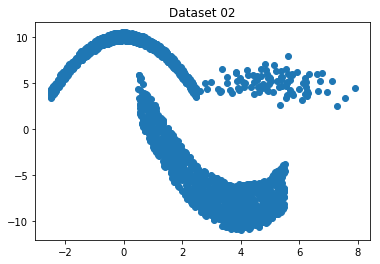

In [7]:
X = create_dataset_02()

plt.scatter(X[:, 0], X[:, 1])
plt.title("Dataset 02")
plt.show()

Dataset 02 appear to have 3 clusters

### 1. KMeans Clustering

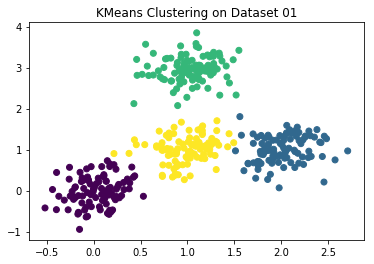

In [8]:
# KMeans Clustering on Dataset 01
kmeans_model = KMeans(n_clusters = 4)
y_pred_kmeans_1 = kmeans_model.fit_predict(Points)

plt.scatter(Points[:, 0], Points[:, 1], c = y_pred_kmeans_1)
plt.title("KMeans Clustering on Dataset 01")
plt.show()

KMeans clustering appear to quantify 4 clusters well for Dataset 01

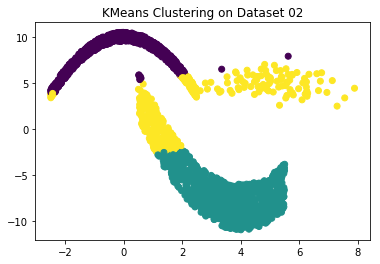

In [9]:
# KMeans Clustering on Dataset 02
kmeans_model = KMeans(n_clusters = 3)
y_pred = kmeans_model.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c = y_pred)
plt.title("KMeans Clustering on Dataset 02")
plt.show()

KMeans clustering does not appear to quantify 3 clusters well for Dataset 02

### 2. DBScan Clustering

In [10]:
# DBScan Clustering on Dataset 01
db = DBSCAN(eps = 0.308, min_samples = 20).fit(Points)

core_samples_mask = np.zeros_like(db.labels_, dtype = bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 24


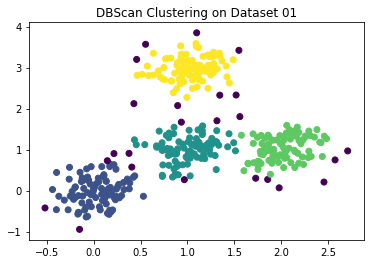

In [11]:
plt.scatter(Points[:, 0], Points[:, 1], c = db.labels_)
plt.title("DBScan Clustering on Dataset 01")
plt.show()

DBScan clustering does not appear to quantify 4 clusters well for Dataset 01 as that of KMeans clustering 

In [12]:
# DBScan Clustering on Dataset 02
db = DBSCAN(eps = .9, min_samples = 20).fit(X)

core_samples_mask = np.zeros_like(db.labels_, dtype = bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 21


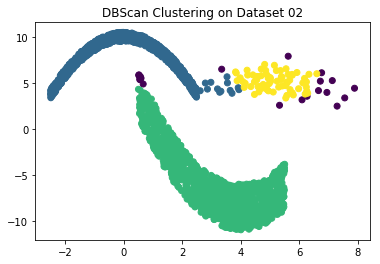

In [13]:
plt.scatter(X[:, 0], X[:, 1], c = db.labels_)
plt.title("DBScan Clustering on Dataset 02")
plt.show()

DBScan clustering appear to quantify 3 clusters better than KMeans clustering for Dataset 02, although with a few noise points

### 3. Agglomerative Clustering

In [15]:
# Agglomerative Clustering on Dataset 01
model1 = AgglomerativeClustering(n_clusters = 4).fit(Points)

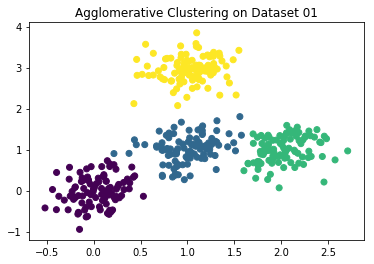

In [16]:
plt.scatter(Points[:, 0], Points[:, 1], c = model1.labels_)
plt.title("Agglomerative Clustering on Dataset 01")
plt.show()

Agglomerative clustering appear to quantify 4 clusters well for Dataset 01. It is almost similar to that of KMeans clustering for this dataset.

In [17]:
# Agglomerative Clustering on Dataset 02
model = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward').fit(X)

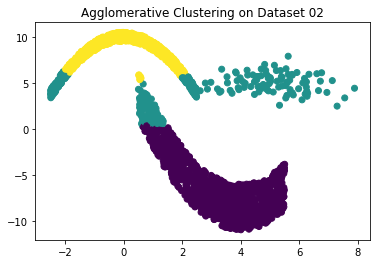

In [18]:
plt.scatter(X[:, 0], X[:, 1], c = model.labels_)
plt.title("Agglomerative Clustering on Dataset 02")
plt.show()

Agglomerative clustering does not appear to quantify 4 clusters well for Dataset 02. Result is almost similar to KMeans clustering.

### Train a Tensorflow classifier to take a point and classify as one of the clusters from KMeans

In [19]:
# Dataset 01
tf_model = tf.keras.Sequential([tf.keras.Input(shape = (2, ), name = 'digits'), 
                                layers.Dense(10, activation = 'relu'), 
                                layers.Dense(4, activation = 'softmax', name = 'predictions')
                               ])

tf_model.compile(optimizer = 'adam', 
                 loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
                 metrics = ['accuracy'], 
                 run_eagerly = True)

tf_model.fit(Points, y_pred_kmeans_1, epochs = 100)

Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
400/400 [==============================] - 0s 1ms/sample - loss: 1.3521 - accuracy: 0.4650
Epoch 2/100
400/400 [==============================] - 0s 575us/sample - loss: 1.3064 - accuracy: 0.4700
Epoch 3/100
400/400 [==============================] - 0s 597us/sample - loss: 1.2606 - accuracy: 0.4450
Epoch 4/100
400/400 [==============================] - 0s 560us/sample - loss: 1.2192 - accuracy: 0.4350
Epoch 5/100
400/400 [==============================] - 0s 510us/sample - loss: 1.1820 - accuracy: 0.4725
Epoch 6/100
400/400 [==============================] - 0s 509us/sample - loss: 1.1465 - accuracy: 0.6025
Epoch 7/100
400/400 [==============================] - 0s 596us/sample - loss: 1.1140 - accuracy: 0.6575
Epoch 8/100
400/400 [==============================] - 0s 555us/sample - loss: 1.0842 - accuracy: 0.6675
Epoch 9/100
400/400 [==============================] - 0s 547us/samp

400/400 [==============================] - 0s 517us/sample - loss: 0.1959 - accuracy: 0.9900
Epoch 76/100
400/400 [==============================] - 0s 540us/sample - loss: 0.1915 - accuracy: 0.9925
Epoch 77/100
400/400 [==============================] - 0s 540us/sample - loss: 0.1872 - accuracy: 0.9900
Epoch 78/100
400/400 [==============================] - 0s 528us/sample - loss: 0.1829 - accuracy: 0.9900
Epoch 79/100
400/400 [==============================] - 0s 550us/sample - loss: 0.1790 - accuracy: 0.9925
Epoch 80/100
400/400 [==============================] - 0s 535us/sample - loss: 0.1749 - accuracy: 0.9925
Epoch 81/100
400/400 [==============================] - 0s 538us/sample - loss: 0.1712 - accuracy: 0.9900
Epoch 82/100
400/400 [==============================] - 0s 545us/sample - loss: 0.1676 - accuracy: 0.9900
Epoch 83/100
400/400 [==============================] - 0s 523us/sample - loss: 0.1641 - accuracy: 0.9925
Epoch 84/100
400/400 [==============================] - 0s 

Tensorflow model has 99.50% accuracy on the training set.

In [27]:
# Taking a point from Dataset 01 to classify
Points_test = create_dataset_01()[:1]
pred = tf_model.predict_classes(Points_test)

C:\Users\gaura\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  app.launch_new_instance()


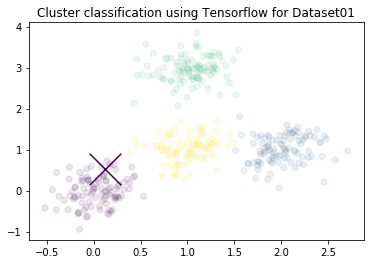

In [28]:
plt.scatter(Points[:, 0], Points[:, 1], c = y_pred_kmeans_1, alpha = 0.1)
plt.scatter(Points_test[:, 0], Points_test[:, 1], c = pred, marker = 'x', s = 1000)
plt.title('Cluster classification using Tensorflow for Dataset01')
plt.show()

Point "X" is classified well using the Tensorflow classifier on Dataset01

In [29]:
# Dataset 02
tf_model2 = tf.keras.Sequential([tf.keras.Input(shape = (2, ), name = 'digits'), 
                                layers.Dense(10, activation = 'sigmoid'), 
                                layers.Dense(3, activation = 'softmax', name = 'predictions')
                                ])

tf_model2.compile(optimizer = 'adam', 
                 loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
                 metrics = ['accuracy'], 
                 run_eagerly = True)

tf_model2.fit(X, y_pred, epochs = 100)

Epoch 1/100
2100/2100 [==============================] - 1s 545us/sample - loss: 1.0597 - accuracy: 0.1952
Epoch 2/100
2100/2100 [==============================] - 1s 573us/sample - loss: 0.7585 - accuracy: 0.7595
Epoch 3/100
2100/2100 [==============================] - 1s 533us/sample - loss: 0.6070 - accuracy: 0.8238
Epoch 4/100
2100/2100 [==============================] - 1s 501us/sample - loss: 0.5250 - accuracy: 0.8205
Epoch 5/100
2100/2100 [==============================] - 1s 523us/sample - loss: 0.4716 - accuracy: 0.8224
Epoch 6/100
2100/2100 [==============================] - 1s 523us/sample - loss: 0.4304 - accuracy: 0.8343
Epoch 7/100
2100/2100 [==============================] - 1s 494us/sample - loss: 0.3962 - accuracy: 0.8433
Epoch 8/100
2100/2100 [==============================] - 1s 484us/sample - loss: 0.3665 - accuracy: 0.8610
Epoch 9/100
2100/2100 [==============================] - 1s 483us/sample - loss: 0.3397 - accuracy: 0.8857
Epoch 10/100
2100/2100 [=============

2100/2100 [==============================] - 2s 773us/sample - loss: 0.0592 - accuracy: 0.9871
Epoch 77/100
2100/2100 [==============================] - 1s 485us/sample - loss: 0.0584 - accuracy: 0.9876
Epoch 78/100
2100/2100 [==============================] - 1s 483us/sample - loss: 0.0578 - accuracy: 0.9895
Epoch 79/100
2100/2100 [==============================] - 1s 504us/sample - loss: 0.0573 - accuracy: 0.9886
Epoch 80/100
2100/2100 [==============================] - 1s 492us/sample - loss: 0.0568 - accuracy: 0.9871 - loss: 0.0499 - accura
Epoch 81/100
2100/2100 [==============================] - 1s 505us/sample - loss: 0.0565 - accuracy: 0.9876
Epoch 82/100
2100/2100 [==============================] - 1s 503us/sample - loss: 0.0559 - accuracy: 0.9890
Epoch 83/100
2100/2100 [==============================] - 1s 512us/sample - loss: 0.0553 - accuracy: 0.9886
Epoch 84/100
2100/2100 [==============================] - 1s 513us/sample - loss: 0.0549 - accuracy: 0.9895
Epoch 85/100
2100

Tensorflow model has 98.95% accuracy on the training set.

In [30]:
# Taking a point from Dataset 02 to classify
X_test = create_dataset_02()[:1]
pred2 = tf_model2.predict_classes(X_test)

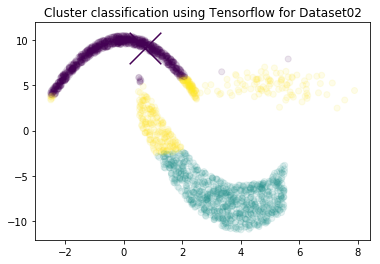

In [31]:
plt.scatter(X[:, 0], X[:, 1], c = y_pred, alpha = 0.1)
plt.scatter(X_test[:, 0], X_test[:, 1], c = pred2, marker = 'x', s = 1000)
plt.title('Cluster classification using Tensorflow for Dataset02')
plt.show()

Point "X" is classified well using the Tensorflow classifier on Dataset02